### Types of missing data:

**MCAR: Missing Completely At Random**  
The missing values in the data set occur completely at random. They don't depend on any other data. Example: when a device such a security camera stops working.  
*How to handle this kind of missing data? Apply data deletion or imputation (imputation is more recommended)*  

**MAR: Missing At Random**  
    The missing values depends on other observed values. Example: devices required a periodic maintenance to ensure consistent operation, so the data will be missing during those maintenance period.  
    *How to handle this kind of missing data? Single or multiple imputation (consider one or several columns during imputation)*  

**MNAR: Missing Not At Random**  
    The missing values depends on the missing values themselves. They are very difficult to identify. And we may not even know that the data is missing. Example: tools have limitations. When attempting to track data out in areas beyond the measurement range, missing values are generated. Example, a scale not detecting very small or very large values.  
    *How to handle this kind of missing data? This kind of missing values require to perform sensivity analysis*  

In [13]:
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Importing DataFrame functions and an extension of the "missing" functions from Pandas

In [14]:
%run utils/u.0.0-pandas_missing_extension.ipynb
%run utils/u.0.1-df_functions.ipynb

#### Getting Processed Data

In [15]:
arg_di_df = pd.read_csv('../data/processed/WDICSV_PROCESSED.csv').clean_names(case_type="snake")

print(arg_di_df.shape)
arg_di_df.info()

(54, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  54 non-null     int64  
 1   it_mlt_main           54 non-null     float64
 2   ny_gdp_mktp_kd        54 non-null     float64
 3   ny_gdp_mktp_kd_zg     54 non-null     float64
 4   ny_gdp_pcap_kd        54 non-null     float64
 5   ny_gdp_pcap_kd_zg     54 non-null     float64
 6   sp_dyn_le00_in        53 non-null     float64
 7   it_cel_sets           50 non-null     float64
 8   sh_dth_imrt           53 non-null     float64
 9   sh_dth_mort           49 non-null     float64
 10  sp_pop_0014_to_zs     54 non-null     float64
 11  sp_pop_1564_to_zs     54 non-null     float64
 12  sp_pop_65_up_to_zs    54 non-null     float64
 13  sp_pop_totl           54 non-null     float64
 14  se_prm_ages           54 non-null     float64
 15  sm_pop_refg     

### Setting initial plots styles

In [16]:
sns.set_style(
    rc={
        "figure.figsize": (8, 6)
    },
    style="whitegrid"
)

#### Getting indicators names and codes

In [17]:
indicators_names = [item + ", " + get_indicator_name(item, True) for item in arg_di_df.columns]
indicators_names

['year, year',
 'it_mlt_main, Fixed telephone subscriptions',
 'ny_gdp_mktp_kd, GDP (constant 2015 US$)',
 'ny_gdp_mktp_kd_zg, GDP growth (annual %)',
 'ny_gdp_pcap_kd, GDP per capita (constant 2015 US$)',
 'ny_gdp_pcap_kd_zg, GDP per capita growth (annual %)',
 'sp_dyn_le00_in, Life expectancy at birth, total (years)',
 'it_cel_sets, Mobile cellular subscriptions',
 'sh_dth_imrt, Number of infant deaths',
 'sh_dth_mort, Number of under-five deaths',
 'sp_pop_0014_to_zs, Population ages 0-14 (% of total population)',
 'sp_pop_1564_to_zs, Population ages 15-64 (% of total population)',
 'sp_pop_65_up_to_zs, Population ages 65 and above (% of total population)',
 'sp_pop_totl, Population, total',
 'se_prm_ages, Primary school starting age (years)',
 'sm_pop_refg, Refugee population by country or territory of asylum',
 'sm_pop_refg_or, Refugee population by country or territory of origin',
 'sp_rur_totl_zs, Rural population (% of total population)',
 'se_pre_enrr, School enrollment, prepr

#### Discarding variables

##### se_prm_ages, Primary school starting age (years)
I'll discard this variable because it always has the same value

In [18]:
if arg_di_df.get("se_prm_ages") is not None:
    print(arg_di_df["se_prm_ages"].value_counts())
    arg_di_df.drop(columns=["se_prm_ages"], inplace=True)

se_prm_ages
6.0    54
Name: count, dtype: int64


/tmp/ipykernel_1122/1420891939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arg_di_df.drop(columns=["se_prm_ages"], inplace=True)


##### se_sec_durs, Secondary education, duration (years)
I'll discard this variable because the duration of secondary education is different in different provinces

In [19]:
if arg_di_df.get("se_sec_durs") is not None:
    print(arg_di_df["se_sec_durs"].value_counts())
    arg_di_df.drop(columns=["se_sec_durs"], inplace=True)

se_sec_durs
5.0    28
6.0    26
Name: count, dtype: int64


/tmp/ipykernel_1122/1127227712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arg_di_df.drop(columns=["se_sec_durs"], inplace=True)


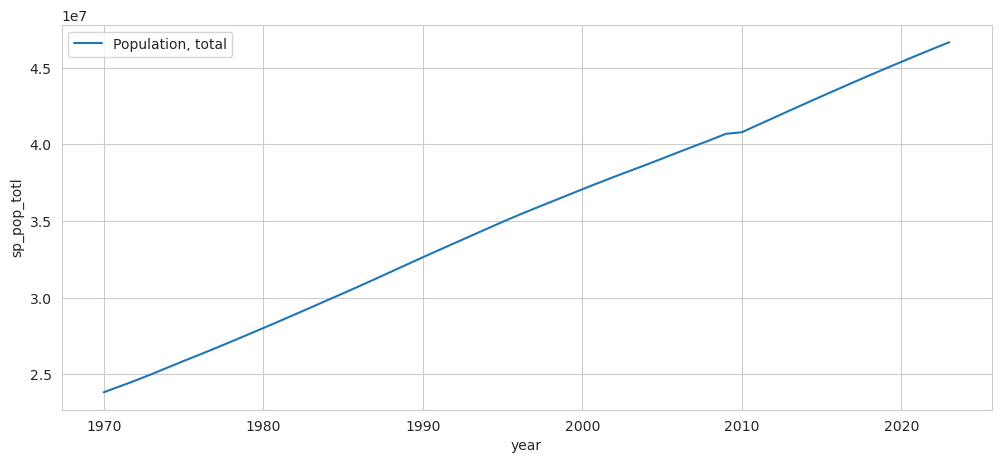

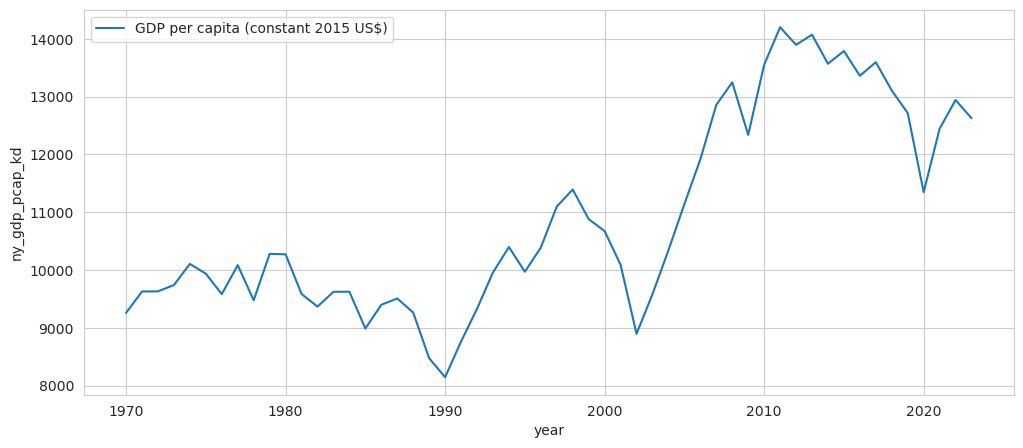

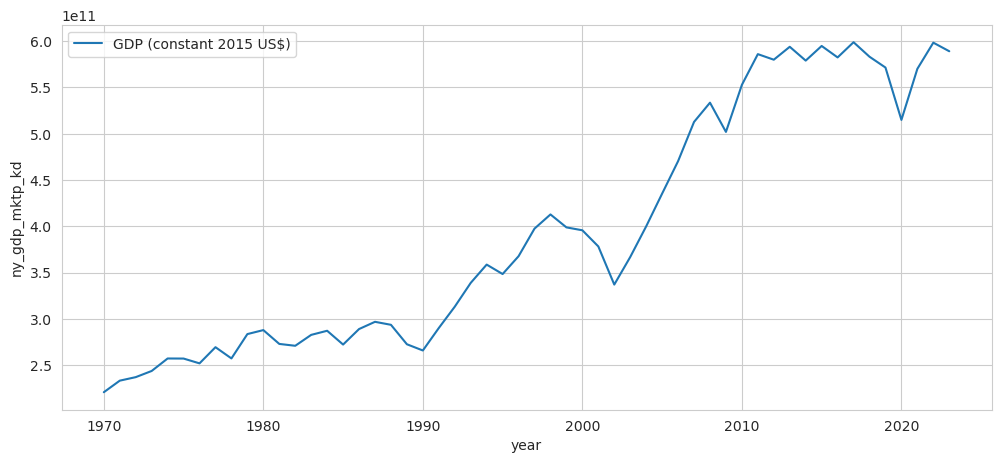

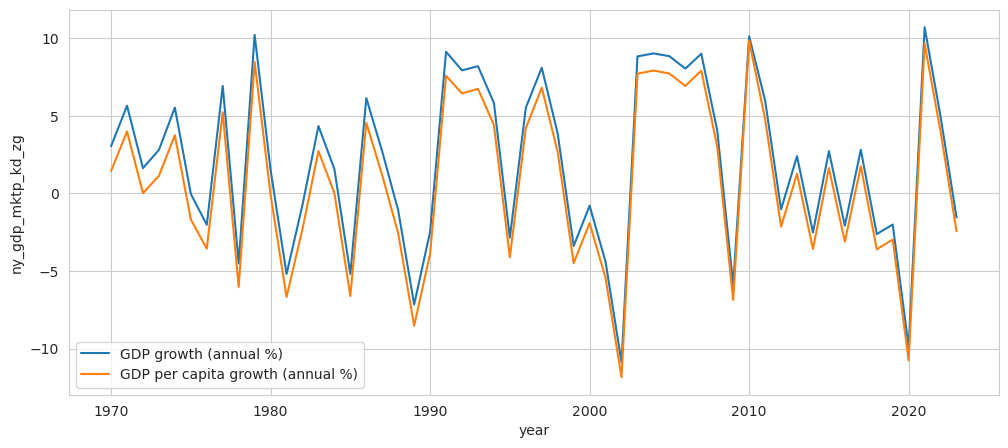

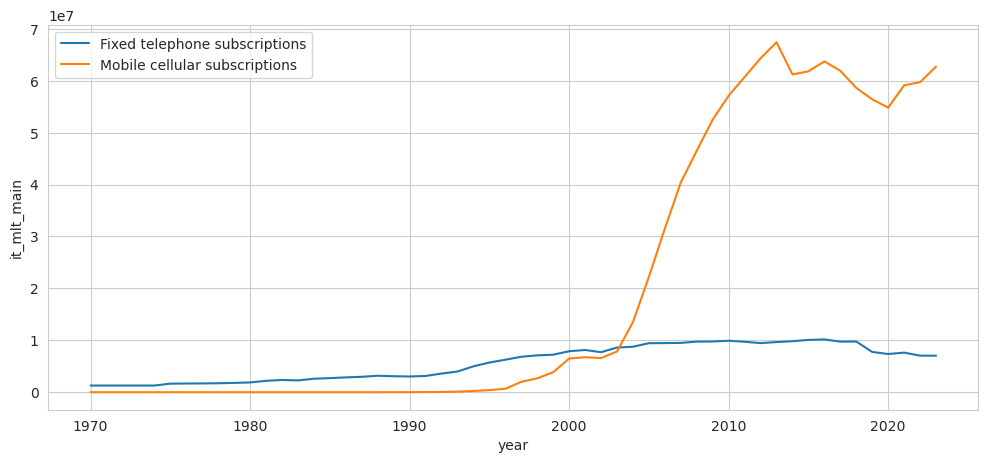

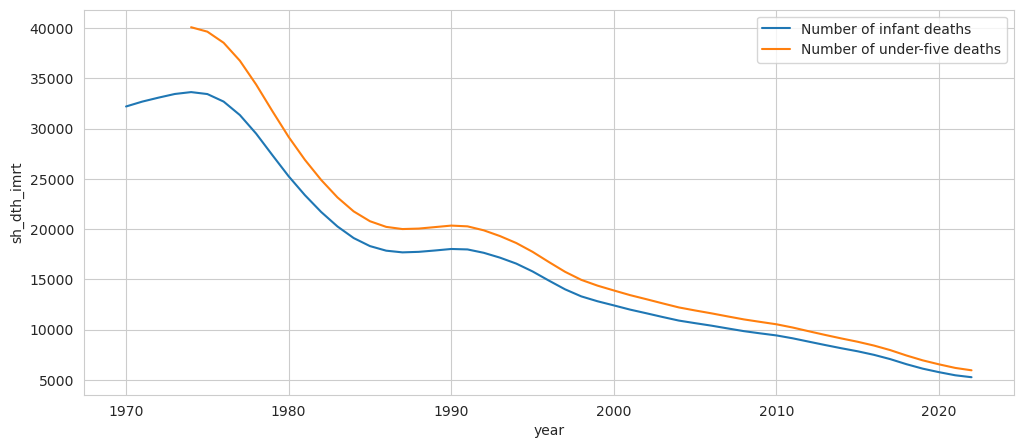

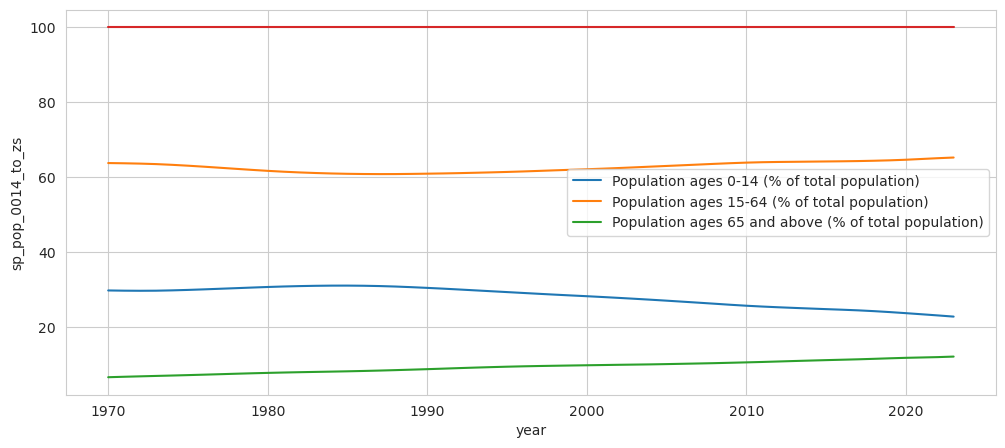

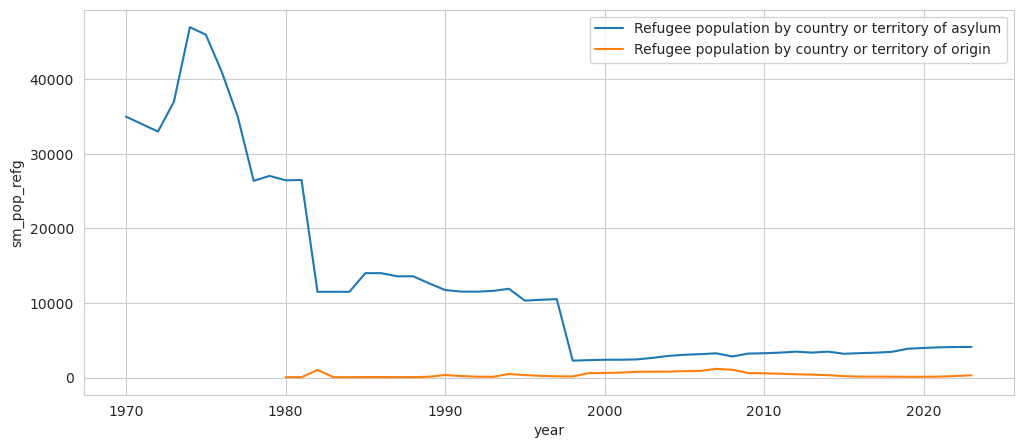

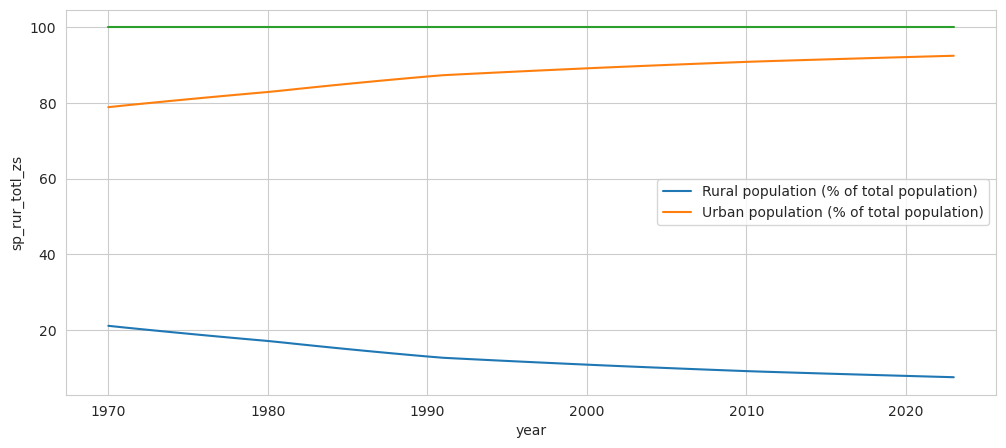

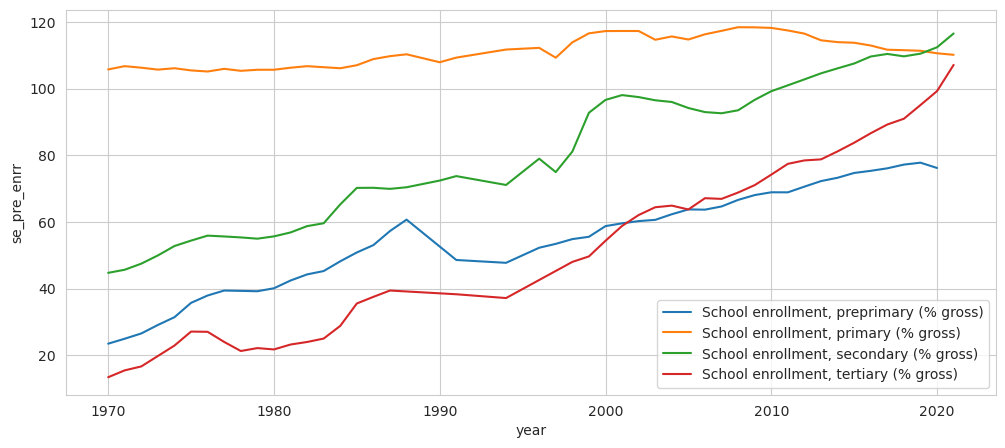

In [22]:
def lineplots(data, x, y=[], figsize=(12,5)):
    plt.figure(figsize=figsize)
    for item in y:
        if data.get(y) is not None:
            plot_label=get_indicator_name(item,True)
        else:
            plot_label=y
        sns.lineplot(x=data[x],y=data[item],label=plot_label)

arg_di_df["sp_pop_00_up_to_zs"] = arg_di_df.apply(lambda x: x["sp_pop_0014_to_zs"] + x["sp_pop_1564_to_zs"] + x["sp_pop_65_up_to_zs"], axis=1)
arg_di_df["sp_totl_zs"] = arg_di_df.apply(lambda x: x["sp_rur_totl_zs"] + x["sp_urb_totl_in_zs"], axis=1)

lineplots(arg_di_df, "year", y=["sp_pop_totl"])
lineplots(arg_di_df, "year", y=["ny_gdp_pcap_kd"])
lineplots(arg_di_df, "year", y=["ny_gdp_mktp_kd"])
lineplots(arg_di_df, "year", y=["ny_gdp_mktp_kd_zg","ny_gdp_pcap_kd_zg"])
lineplots(arg_di_df, "year", y=["it_mlt_main","it_cel_sets"])
lineplots(arg_di_df, "year", y=["sh_dth_imrt","sh_dth_mort"])
lineplots(arg_di_df, "year", y=["sp_pop_0014_to_zs","sp_pop_1564_to_zs","sp_pop_65_up_to_zs","sp_pop_00_up_to_zs"])
lineplots(arg_di_df, "year", y=["sm_pop_refg","sm_pop_refg_or"])
lineplots(arg_di_df, "year", y=["sp_rur_totl_zs","sp_urb_totl_in_zs","sp_totl_zs"])
lineplots(arg_di_df, "year", y=["se_pre_enrr","se_prm_enrr","se_sec_enrr","se_ter_enrr"])

plt.show()

In [24]:
arg_di_df = arg_di_df.assign(gdp_higher_than_past_year = lambda x: x["ny_gdp_mktp_kd_zg"] > 0)
arg_di_df[["gdp_higher_than_past_year"]].value_counts()

gdp_higher_than_past_year
True                         32
False                        22
Name: count, dtype: int64

In [23]:
def get_greatest_year_range(row):
    if(row["sp_pop_0014_to_zs"] > row["sp_pop_1564_to_zs"] and row["sp_pop_0014_to_zs"] > row["sp_pop_65_up_to_zs"]): return "0 to 14 years"
    elif(row["sp_pop_1564_to_zs"] > row["sp_pop_65_up_to_zs"] and row["sp_pop_1564_to_zs"] > row["sp_pop_0014_to_zs"]): return "15 to 64 years"
    elif(row["sp_pop_65_up_to_zs"] > row["sp_pop_0014_to_zs"] and row["sp_pop_65_up_to_zs"] > row["sp_pop_1564_to_zs"]): return "65 and above"

arg_di_df["greatest_year_range"] = arg_di_df.apply(lambda x: get_greatest_year_range(x), axis=1)
arg_di_df[["greatest_year_range", ]].value_counts()


greatest_year_range
15 to 64 years         54
Name: count, dtype: int64

Evaluación del mecanismo de valores faltantes por prueba de t-test

Información
    two-sided: las medias de las distribuciones subyacentes a las muestras son desiguales.
    less: la media de la distribución subyacente a la primera muestra es menor que la media de la distribución subyacente a la segunda muestra.
    greater: la media de la distribución subyacente a la primera muestra es mayor que la media de la distribución subyacente a la segunda muestra.


/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


TtestResult(statistic=array([6.65315136]), pvalue=array([8.53550812e-09]), df=array([62.]))